<a href="https://colab.research.google.com/github/IsisMaranhao/TCC_USPESALQ/blob/main/2_ARROZ_LICENSE_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr 12 00:56:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Endereço - Kaglle dataset
# https://www.kaggle.com/datasets/alikhalilit98/rice-image-dataset-for-object-detection

In [ ]:
!pip install kaggle --upgrade
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from platform import python_version
print("Versão Python:", python_version())

Versão Python: 3.9.16


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"isismaranho","key":"2ed35c5c137ac60117f051206dbeccf2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!echo > ~/.kaggle/kaggle.json
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d alikhalilit98/rice-image-dataset-for-object-detection

100% 462M/462M [00:21<00:00, 27.5MB/s]
100% 462M/462M [00:21<00:00, 22.5MB/s]


In [ ]:
import zipfile
from google.colab import drive

zip_ref = zipfile.ZipFile("/content/rice-image-dataset-for-object-detection.zip", 'r')
zip_ref.extractall("/content/sample_data")
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd

import datetime
import timeit

import itertools
import glob
import cv2

import os
import os.path
from pathlib import Path

import seaborn as sns
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from matplotlib import gridspec 
from google.colab.patches import cv2_imshow

import shutil

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model

from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Lambda
 
from keras.optimizers import Adam, SGD, RMSprop

from keras.applications import VGG16, ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical, plot_model

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

VERIFICANDO SE AS IMAGENS ESTÃO NA PASTA CORRETAMENTE

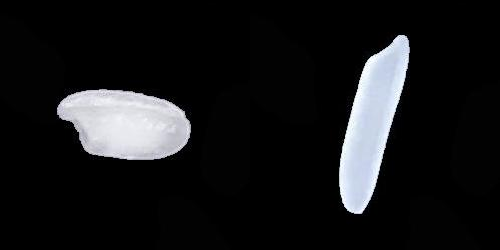

In [ ]:
img1=cv2.imread('/content/sample_data/Rice_Image_Dataset_OD/Arborio/Arborio (1).jpg')
img2=cv2.imread('/content/sample_data/Rice_Image_Dataset_OD/Basmati/Basmati (1).jpg')

final_image = cv2.hconcat((img1, img2))
 
cv2_imshow(final_image)

In [ ]:
# Verificando o tipo de dados da matriz da imagem
print('Dtype da imagem1 é {} e o Dtype da imagem2 é {} \n'
     .format(img1.dtype,img2.dtype))

# Verificando a altura da imagem
print('A altura da imagem1 é {} e a altura da imagem2 é {}'
     .format(img1.shape[0],img2.shape[0]))

# Verificando a largura da imagem
print('A largura da imagem1 é {} e a largura da imagem2 é {} \n'
     .format(img1.shape[1],img2.shape[1]))

# Verificando o número de canais da imagem
print('O número de canais da imagem1 é {} e o número de canais da imagem2 é {}'
     .format(img1.shape[2],img2.shape[2]))

Dtype da imagem1 é uint8 e o Dtype da imagem2 é uint8 

A altura da imagem1 é 250 e a altura da imagem2 é 250
A largura da imagem1 é 250 e a largura da imagem2 é 250 

O número de canais da imagem1 é 3 e o número de canais da imagem2 é 3


CRIANDO UMA PASTA COM NÚMEROS MENORES DE IMAGENS PARA APLICAR O MODELO

In [ ]:
diretorio = "/content/sample_data/"
nome_da_pasta = "Rice_Dataset_menor"

caminho_completo = os.path.join(diretorio, nome_da_pasta)
os.makedirs(caminho_completo, exist_ok=True)

In [ ]:
nomes_das_pastas=["Arborio","Basmati","Ipsala","Jasmine","Karacadag"]

for nome in nomes_das_pastas:
  diretorio = "/content/sample_data/Rice_Dataset_menor"
  caminho_completo = os.path.join(diretorio, nome)
  os.makedirs(caminho_completo, exist_ok=True)

In [ ]:
im_shape = (250,250)
seed = 10
BATCH_SIZE = 125 

nomes_das_pastas=["Arborio","Basmati","Ipsala","Jasmine","Karacadag"]

caminho_antigo="/content/sample_data/Rice_Image_Dataset_OD/"
caminho_novo="/content/sample_data/Rice_Dataset_menor/"

data = []

for pasta in nomes_das_pastas:
  src_folder = caminho_antigo + pasta
  dst_folder = caminho_novo + pasta

  # Obtenha a lista de todas as imagens .jpg na pasta de origem
  src_files = glob.glob(f"{src_folder}/*.jpg")[:750] # Quantidade de imagens de cada grupo

  # Move cada imagem para a pasta de destino
  for src_file in src_files:
    shutil.move(src_file, dst_folder)

    data_folder = os.listdir(dst_folder)
    data.extend(data_folder)

In [ ]:
arborio_images = []
basmati_images = []
ipsala_images = []
jasmine_images = []
karacadag_images = []

for img_path in glob.glob('/content/sample_data/Rice_Dataset_menor/Arborio/*.jpg'):
  arborio_images.append(mpimg.imread(img_path))

for img_path in glob.glob('/content/sample_data/Rice_Dataset_menor/Basmati/*.jpg'):
  basmati_images.append(mpimg.imread(img_path))

for img_path in glob.glob('/content/sample_data/Rice_Dataset_menor/Ipsala/*.jpg'):
  ipsala_images.append(mpimg.imread(img_path))

for img_path in glob.glob('/content/sample_data/Rice_Dataset_menor/Jasmine/*.jpg'):
  jasmine_images.append(mpimg.imread(img_path))
    
for img_path in glob.glob('/content/sample_data/Rice_Dataset_menor/Karacadag/*.jpg'):
  karacadag_images.append(mpimg.imread(img_path))

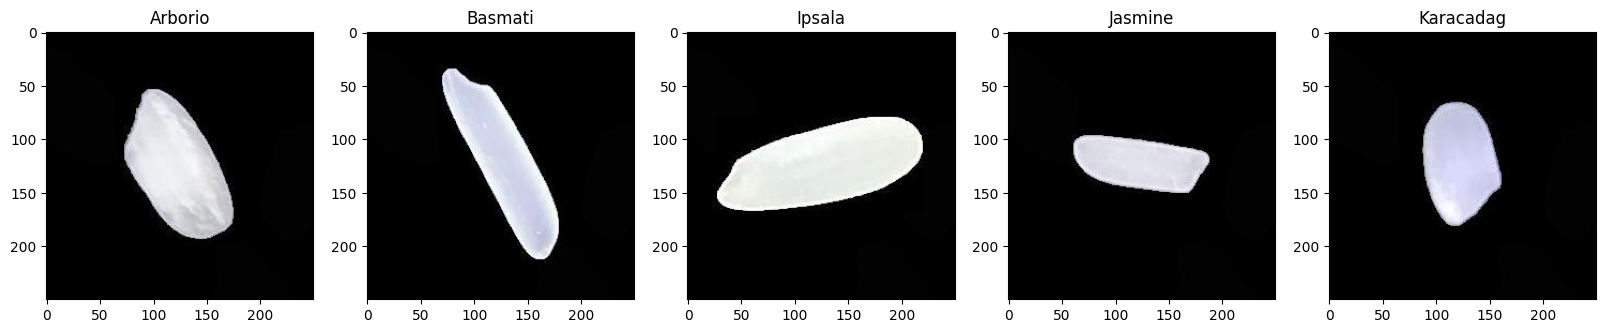

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(20,20))

axs[0].imshow(arborio_images[1], cmap='gray')
axs[0].set_title('Arborio')

axs[1].imshow(basmati_images[1], cmap='gray')
axs[1].set_title('Basmati')

axs[2].imshow(ipsala_images[1], cmap='gray')
axs[2].set_title('Ipsala')

axs[3].imshow(jasmine_images[1], cmap='gray')
axs[3].set_title('Jasmine')

axs[4].imshow(karacadag_images[1], cmap='gray')
axs[4].set_title('Karacadag')

plt.show()

In [ ]:
print(len(arborio_images))
print(len(basmati_images))
print(len(ipsala_images))
print(len(jasmine_images))
print(len(karacadag_images))

750
750
750
750
750


In [ ]:
diretorio = "/content/sample_data/"
nome_da_pasta = "Rice_Dataset_menor"

caminho_completo = os.path.join(diretorio, nome_da_pasta)
os.makedirs(caminho_completo, exist_ok=True)

In [ ]:
data=caminho_completo

diretorio_completo = Path(caminho_completo)
caminhos_arquivos_png = list(diretorio_completo.glob("**/*.jpg"))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], caminhos_arquivos_png))

In [ ]:
print(len(labels))

3750


In [ ]:
# Caminhos & labels...
filepaths = pd.Series(caminhos_arquivos_png, name = 'File').astype(str)
labels = pd.Series(labels, name = 'Label')

# Concatenando...
df = pd.concat([filepaths, labels], axis=1)

# Mudando os nomes...
df['Label'].replace({"non_fire_images":"nofire","fire_images":"fire"}, inplace=True)

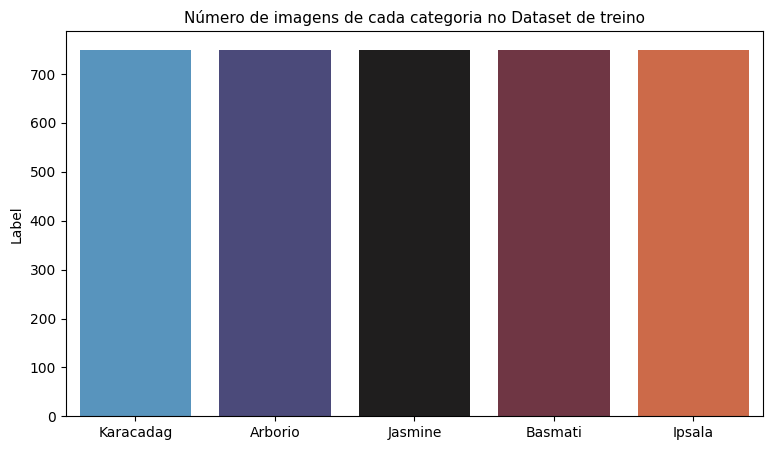

In [ ]:
# Visualizando os dados do dataset em um barplot
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc, palette = "icefire")
plt.title("Número de imagens de cada categoria no Dataset de treino", fontsize = 11)
plt.savefig("/content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/grafico_quantidade_imagens_treino_VGG16.jpg")
plt.show()

In [ ]:
print(vc.index[0])
print(vc.index[1])
print(vc.index[2])
print(vc.index[3])
print(vc.index[4])

Karacadag
Arborio
Jasmine
Basmati
Ipsala


CRIANDO BASE DE TREINO E VALIDAÇÃO

In [ ]:
# Misturando o dataframe e resetando o index
df = df.sample(frac = 1, random_state = 83).reset_index(drop = True)

# Resultado
df.head()

,File,Label
0,/content/sample_data/Rice_Dataset_menor/Karaca...,Karacadag
1,/content/sample_data/Rice_Dataset_menor/Karaca...,Karacadag
2,/content/sample_data/Rice_Dataset_menor/Arbori...,Arborio
3,/content/sample_data/Rice_Dataset_menor/Karaca...,Karacadag
4,/content/sample_data/Rice_Dataset_menor/Karaca...,Karacadag


In [ ]:
df_train, df_val = train_test_split(df, train_size = 0.7, random_state = 86)

df_train.head()
df_val.head()
print('Qtde de treino: {}'.format(len(df_train)))
print('Qtde de validaçao: {}'.format(len(df_val)))

Qtde de treino: 2625
Qtde de validaçao: 1125


In [ ]:
# Visualizando os dados em ambos datasets
print('Dataset de treinamento: \n')

print(f'Número de imagens: {df_train.shape[0]} \n')

print(f'Número de imagens Basmati: {df_train["Label"].value_counts()[0]}')
print(f'Número de imagens Jasmine: {df_train["Label"].value_counts()[1]}')
print(f'Número de imagens Karacadag: {df_train["Label"].value_counts()[2]}')
print(f'Número de imagens Arborio: {df_train["Label"].value_counts()[3]}')
print(f'Número de imagens Ipsala: {df_train["Label"].value_counts()[4]} \n')
      
print('Dataset de teste: \n')
      
print(f'Número de imagens no dataset de validacao: {df_val.shape[0]} \n')

print(f'Número de imagens Basmati: {df_val["Label"].value_counts()[0]}')
print(f'Número de imagens Jasmine: {df_val["Label"].value_counts()[1]}')
print(f'Número de imagens Karacadag: {df_val["Label"].value_counts()[2]}')
print(f'Número de imagens Arborio: {df_val["Label"].value_counts()[3]}')
print(f'Número de imagens Ipsala: {df_val["Label"].value_counts()[4]}')

Dataset de treinamento: 

Número de imagens: 2625 

Número de imagens Basmati: 534
Número de imagens Jasmine: 532
Número de imagens Karacadag: 527
Número de imagens Arborio: 520
Número de imagens Ipsala: 512 

Dataset de teste: 

Número de imagens no dataset de validacao: 1125 

Número de imagens Basmati: 238
Número de imagens Jasmine: 230
Número de imagens Karacadag: 223
Número de imagens Arborio: 218
Número de imagens Ipsala: 216


In [ ]:
#Separando x_train e y_train

y_train = df_train["Label"]
x_train = df_train.drop(labels = ["Label"],axis = 1)
print(x_train.head())

                                                   File
825   /content/sample_data/Rice_Dataset_menor/Jasmin...
1742  /content/sample_data/Rice_Dataset_menor/Arbori...
2484  /content/sample_data/Rice_Dataset_menor/Arbori...
2389  /content/sample_data/Rice_Dataset_menor/Karaca...
3036  /content/sample_data/Rice_Dataset_menor/Jasmin...


In [ ]:
x_train.shape

(2625, 1)

In [ ]:
# Separando x_val e y_val

y_val = df_val["Label"]
x_val = df_val.drop(labels = ["Label"],axis = 1)
print(x_val.head())

                                                   File
1182  /content/sample_data/Rice_Dataset_menor/Basmat...
1308  /content/sample_data/Rice_Dataset_menor/Basmat...
1390  /content/sample_data/Rice_Dataset_menor/Karaca...
2883  /content/sample_data/Rice_Dataset_menor/Ipsala...
1675  /content/sample_data/Rice_Dataset_menor/Ipsala...


In [ ]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(y_train)
Y_val = label_encoder.fit_transform(y_val)

In [ ]:
print(len(Y_train))
print(Y_train)

2625
[3 0 0 ... 1 4 3]


In [ ]:
print(len(Y_val))
print(Y_val)

1125
[1 1 4 ... 2 4 3]


True

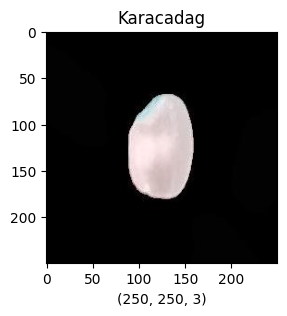

In [ ]:
# Observando as imagens do dataset de treino
figure = plt.figure(figsize=(3,3))
x = cv2.imread(df_train["File"][0])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df_train["Label"][0])
cv2.imwrite("/content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/grao.jpg", x)

In [ ]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.3)

In [ ]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(data, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(data, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(data, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())

print('Classes: '+str(classes))
num_classes  = len(classes)

Found 3000 images belonging to 5 classes.
Found 1125 images belonging to 5 classes.
Found 3750 images belonging to 5 classes.
Classes: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


ARQUITETURA VGG16

In [ ]:
inputs = tf.keras.Input(shape=(250, 250, 3))

model2 = VGG16(weights=None, include_top=False)(inputs)

x = tf.keras.layers.Flatten()(model2)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 27,562,821
Trainable params: 27,562,821
Non-trainable params: 0
_________________________________________________________________


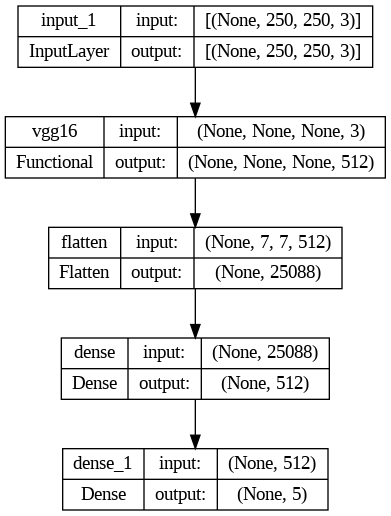

In [ ]:
plot_model(model2, to_file='model.png', show_layer_names = True , show_shapes = True)

In [ ]:
callback_1 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

caminho_de_arquivo = "/content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/"
callback_2 = keras.callbacks.ModelCheckpoint(caminho_de_arquivo, monitor='val_loss', verbose=1, patience=10, save_best_only=True, mode='min')

callback_3 = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, min_delta=0.1, patience=10, verbose=1)

In [ ]:
inicio = timeit.default_timer()

In [ ]:
epochs = 100

history2 = model2.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = epochs,
    callbacks=[callback_1, callback_2, callback_3]
)

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 82.7435 - accuracy: 0.1930
Epoch 1: val_loss improved from inf to 1.60730, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 75s 2s/step - loss: 82.7435 - accuracy: 0.1930 - val_loss: 1.6073 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 1.5964 - accuracy: 0.2063
Epoch 2: val_loss did not improve from 1.60730
24/24 [==============================] - 43s 2s/step - loss: 1.5964 - accuracy: 0.2063 - val_loss: 1.6124 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 1.6168 - accuracy: 0.1947
Epoch 3: val_loss improved from 1.60730 to 1.56667, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 47s 2s/step - loss: 1.6168 - accuracy: 0.1947 - val_loss: 1.5667 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 1.6013 - accuracy: 0.2330
Epoch 4: val_loss improved from 1.56667 to 1.55190, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 46s 2s/step - loss: 1.6013 - accuracy: 0.2330 - val_loss: 1.5519 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 5/100
24/24 [==============================] - ETA: 0s - loss: 1.8400 - accuracy: 0.2143
Epoch 5: val_loss did not improve from 1.55190
24/24 [==============================] - 43s 2s/step - loss: 1.8400 - accuracy: 0.2143 - val_loss: 1.6200 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 6/100
24/24 [==============================] - ETA: 0s - loss: 1.6484 - accuracy: 0.1980
Epoch 6: val_loss did not improve from 1.55190
24/24 [==============================] - 43s 2s/step - loss: 1.6484 - accuracy: 0.1980 - val_loss: 1.6130 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 7/100
24/24 [==============================] - ETA: 0s - loss: 1.6115 - accuracy: 0.2000
Epoch 7: val_loss did not improve from 1.55190
24/24 [==============================] - 43s 2s/step - loss: 1.6115 - accuracy: 0.2000 - val_loss: 1.6093 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 

24/24 [==============================] - 47s 2s/step - loss: 1.5935 - accuracy: 0.2330 - val_loss: 1.5273 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 14/100
24/24 [==============================] - ETA: 0s - loss: 1.4427 - accuracy: 0.2920
Epoch 14: val_loss improved from 1.52733 to 1.28845, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 47s 2s/step - loss: 1.4427 - accuracy: 0.2920 - val_loss: 1.2884 - val_accuracy: 0.5084 - lr: 1.0000e-04
Epoch 15/100
24/24 [==============================] - ETA: 0s - loss: 1.1304 - accuracy: 0.5233
Epoch 15: val_loss improved from 1.28845 to 1.22783, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 47s 2s/step - loss: 1.1304 - accuracy: 0.5233 - val_loss: 1.2278 - val_accuracy: 0.4587 - lr: 1.0000e-04
Epoch 16/100
24/24 [==============================] - ETA: 0s - loss: 0.9962 - accuracy: 0.5217
Epoch 16: val_loss improved from 1.22783 to 0.90666, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 46s 2s/step - loss: 0.9962 - accuracy: 0.5217 - val_loss: 0.9067 - val_accuracy: 0.5929 - lr: 1.0000e-04
Epoch 17/100
24/24 [==============================] - ETA: 0s - loss: 0.9201 - accuracy: 0.5640
Epoch 17: val_loss improved from 0.90666 to 0.85761, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 46s 2s/step - loss: 0.9201 - accuracy: 0.5640 - val_loss: 0.8576 - val_accuracy: 0.5947 - lr: 1.0000e-04
Epoch 18/100
24/24 [==============================] - ETA: 0s - loss: 0.8736 - accuracy: 0.5830
Epoch 18: val_loss improved from 0.85761 to 0.84307, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 47s 2s/step - loss: 0.8736 - accuracy: 0.5830 - val_loss: 0.8431 - val_accuracy: 0.6053 - lr: 1.0000e-04
Epoch 19/100
24/24 [==============================] - ETA: 0s - loss: 0.8709 - accuracy: 0.5800
Epoch 19: val_loss did not improve from 0.84307
24/24 [==============================] - 43s 2s/step - loss: 0.8709 - accuracy: 0.5800 - val_loss: 0.9667 - val_accuracy: 0.5876 - lr: 1.0000e-04
Epoch 20/100
24/24 [==============================] - ETA: 0s - loss: 0.8434 - accuracy: 0.5943
Epoch 20: val_loss improved from 0.84307 to 0.80127, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 46s 2s/step - loss: 0.8434 - accuracy: 0.5943 - val_loss: 0.8013 - val_accuracy: 0.6187 - lr: 1.0000e-04
Epoch 21/100
24/24 [==============================] - ETA: 0s - loss: 0.8348 - accuracy: 0.6163
Epoch 21: val_loss improved from 0.80127 to 0.79021, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 47s 2s/step - loss: 0.8348 - accuracy: 0.6163 - val_loss: 0.7902 - val_accuracy: 0.6356 - lr: 1.0000e-04
Epoch 22/100
24/24 [==============================] - ETA: 0s - loss: 0.8074 - accuracy: 0.6250
Epoch 22: val_loss improved from 0.79021 to 0.74021, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 47s 2s/step - loss: 0.8074 - accuracy: 0.6250 - val_loss: 0.7402 - val_accuracy: 0.6533 - lr: 1.0000e-04
Epoch 23/100
24/24 [==============================] - ETA: 0s - loss: 0.8049 - accuracy: 0.6140
Epoch 23: val_loss improved from 0.74021 to 0.72981, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 46s 2s/step - loss: 0.8049 - accuracy: 0.6140 - val_loss: 0.7298 - val_accuracy: 0.6596 - lr: 1.0000e-04
Epoch 24/100
24/24 [==============================] - ETA: 0s - loss: 0.7541 - accuracy: 0.6603
Epoch 24: val_loss did not improve from 0.72981
24/24 [==============================] - 43s 2s/step - loss: 0.7541 - accuracy: 0.6603 - val_loss: 0.7324 - val_accuracy: 0.6631 - lr: 1.0000e-04
Epoch 25/100
24/24 [==============================] - ETA: 0s - loss: 0.7442 - accuracy: 0.6553
Epoch 25: val_loss improved from 0.72981 to 0.66949, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 47s 2s/step - loss: 0.7442 - accuracy: 0.6553 - val_loss: 0.6695 - val_accuracy: 0.6844 - lr: 1.0000e-04
Epoch 26/100
24/24 [==============================] - ETA: 0s - loss: 0.7490 - accuracy: 0.6613
Epoch 26: val_loss did not improve from 0.66949
24/24 [==============================] - 43s 2s/step - loss: 0.7490 - accuracy: 0.6613 - val_loss: 0.7930 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 27/100
24/24 [==============================] - ETA: 0s - loss: 0.6977 - accuracy: 0.6940
Epoch 27: val_loss improved from 0.66949 to 0.64580, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 47s 2s/step - loss: 0.6977 - accuracy: 0.6940 - val_loss: 0.6458 - val_accuracy: 0.7271 - lr: 1.0000e-04
Epoch 28/100
24/24 [==============================] - ETA: 0s - loss: 0.6305 - accuracy: 0.7347
Epoch 28: val_loss did not improve from 0.64580
24/24 [==============================] - 43s 2s/step - loss: 0.6305 - accuracy: 0.7347 - val_loss: 0.9063 - val_accuracy: 0.5884 - lr: 1.0000e-04
Epoch 29/100
24/24 [==============================] - ETA: 0s - loss: 0.6152 - accuracy: 0.7357
Epoch 29: val_loss improved from 0.64580 to 0.47432, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 46s 2s/step - loss: 0.6152 - accuracy: 0.7357 - val_loss: 0.4743 - val_accuracy: 0.8489 - lr: 1.0000e-04
Epoch 30/100
24/24 [==============================] - ETA: 0s - loss: 0.5361 - accuracy: 0.7813
Epoch 30: val_loss did not improve from 0.47432
24/24 [==============================] - 43s 2s/step - loss: 0.5361 - accuracy: 0.7813 - val_loss: 0.6327 - val_accuracy: 0.7618 - lr: 1.0000e-04
Epoch 31/100
24/24 [==============================] - ETA: 0s - loss: 0.4800 - accuracy: 0.8177
Epoch 31: val_loss did not improve from 0.47432
24/24 [==============================] - 43s 2s/step - loss: 0.4800 - accuracy: 0.8177 - val_loss: 0.7578 - val_accuracy: 0.7244 - lr: 1.0000e-04
Epoch 32/100
24/24 [==============================] - ETA: 0s - loss: 0.4043 - accuracy: 0.8457
Epoch 32: val_loss did not improve from 0.47432
24/24 [==============================] - 43s 2s/step - loss: 0.4043 - accuracy: 0.8457 - val_loss: 1.4994 - val_accuracy: 0.5902 -

24/24 [==============================] - 47s 2s/step - loss: 0.4017 - accuracy: 0.8507 - val_loss: 0.2304 - val_accuracy: 0.9467 - lr: 1.0000e-04
Epoch 34/100
24/24 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.8887
Epoch 34: val_loss did not improve from 0.23037
24/24 [==============================] - 43s 2s/step - loss: 0.3021 - accuracy: 0.8887 - val_loss: 0.2970 - val_accuracy: 0.9191 - lr: 1.0000e-04
Epoch 35/100
24/24 [==============================] - ETA: 0s - loss: 0.2462 - accuracy: 0.9063
Epoch 35: val_loss did not improve from 0.23037
24/24 [==============================] - 43s 2s/step - loss: 0.2462 - accuracy: 0.9063 - val_loss: 1.7680 - val_accuracy: 0.6169 - lr: 1.0000e-04
Epoch 36/100
24/24 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.8903
Epoch 36: val_loss did not improve from 0.23037
24/24 [==============================] - 43s 2s/step - loss: 0.3230 - accuracy: 0.8903 - val_loss: 0.4294 - val_accuracy: 0.9040 -

24/24 [==============================] - 46s 2s/step - loss: 0.1600 - accuracy: 0.9480 - val_loss: 0.1475 - val_accuracy: 0.9511 - lr: 1.0000e-04
Epoch 39/100
24/24 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9630
Epoch 39: val_loss did not improve from 0.14748
24/24 [==============================] - 43s 2s/step - loss: 0.1093 - accuracy: 0.9630 - val_loss: 0.3646 - val_accuracy: 0.9031 - lr: 1.0000e-04
Epoch 40/100
24/24 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9617
Epoch 40: val_loss did not improve from 0.14748
24/24 [==============================] - 43s 2s/step - loss: 0.1142 - accuracy: 0.9617 - val_loss: 0.3343 - val_accuracy: 0.9049 - lr: 1.0000e-04
Epoch 41/100
24/24 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9557
Epoch 41: val_loss improved from 0.14748 to 0.08759, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 47s 2s/step - loss: 0.1236 - accuracy: 0.9557 - val_loss: 0.0876 - val_accuracy: 0.9716 - lr: 1.0000e-04
Epoch 42/100
24/24 [==============================] - ETA: 0s - loss: 0.0960 - accuracy: 0.9653
Epoch 42: val_loss did not improve from 0.08759
24/24 [==============================] - 43s 2s/step - loss: 0.0960 - accuracy: 0.9653 - val_loss: 0.1394 - val_accuracy: 0.9529 - lr: 1.0000e-04
Epoch 43/100
24/24 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9650
Epoch 43: val_loss did not improve from 0.08759
24/24 [==============================] - 43s 2s/step - loss: 0.1050 - accuracy: 0.9650 - val_loss: 0.1075 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 44/100
24/24 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9693
Epoch 44: val_loss improved from 0.08759 to 0.08514, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 46s 2s/step - loss: 0.0944 - accuracy: 0.9693 - val_loss: 0.0851 - val_accuracy: 0.9733 - lr: 1.0000e-04
Epoch 45/100
24/24 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9593
Epoch 45: val_loss did not improve from 0.08514
24/24 [==============================] - 43s 2s/step - loss: 0.1077 - accuracy: 0.9593 - val_loss: 0.0932 - val_accuracy: 0.9733 - lr: 1.0000e-04
Epoch 46/100
24/24 [==============================] - ETA: 0s - loss: 0.0801 - accuracy: 0.9723
Epoch 46: val_loss improved from 0.08514 to 0.05987, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 46s 2s/step - loss: 0.0801 - accuracy: 0.9723 - val_loss: 0.0599 - val_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 47/100
24/24 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.9690
Epoch 47: val_loss improved from 0.05987 to 0.05012, saving model to /content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/


24/24 [==============================] - 47s 2s/step - loss: 0.0837 - accuracy: 0.9690 - val_loss: 0.0501 - val_accuracy: 0.9831 - lr: 1.0000e-04
Epoch 48/100
24/24 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9580
Epoch 48: val_loss did not improve from 0.05012
24/24 [==============================] - 43s 2s/step - loss: 0.1140 - accuracy: 0.9580 - val_loss: 0.1057 - val_accuracy: 0.9698 - lr: 1.0000e-04
Epoch 49/100
24/24 [==============================] - ETA: 0s - loss: 0.1010 - accuracy: 0.9637
Epoch 49: val_loss did not improve from 0.05012
24/24 [==============================] - 43s 2s/step - loss: 0.1010 - accuracy: 0.9637 - val_loss: 0.0543 - val_accuracy: 0.9822 - lr: 1.0000e-04
Epoch 50/100
24/24 [==============================] - ETA: 0s - loss: 0.1004 - accuracy: 0.9620
Epoch 50: val_loss did not improve from 0.05012
24/24 [==============================] - 43s 2s/step - loss: 0.1004 - accuracy: 0.9620 - val_loss: 0.2701 - val_accuracy: 0.9244 -

In [ ]:
fim = timeit.default_timer()

In [ ]:
duracao_segundos = fim - inicio
duracao_formatada = str(datetime.timedelta(seconds=duracao_segundos))
inicio_formatado = datetime.datetime.fromtimestamp(inicio).strftime('%Y-%m-%d %H:%M:%S.%f')
fim_formatado = datetime.datetime.fromtimestamp(fim).strftime('%Y-%m-%d %H:%M:%S.%f')

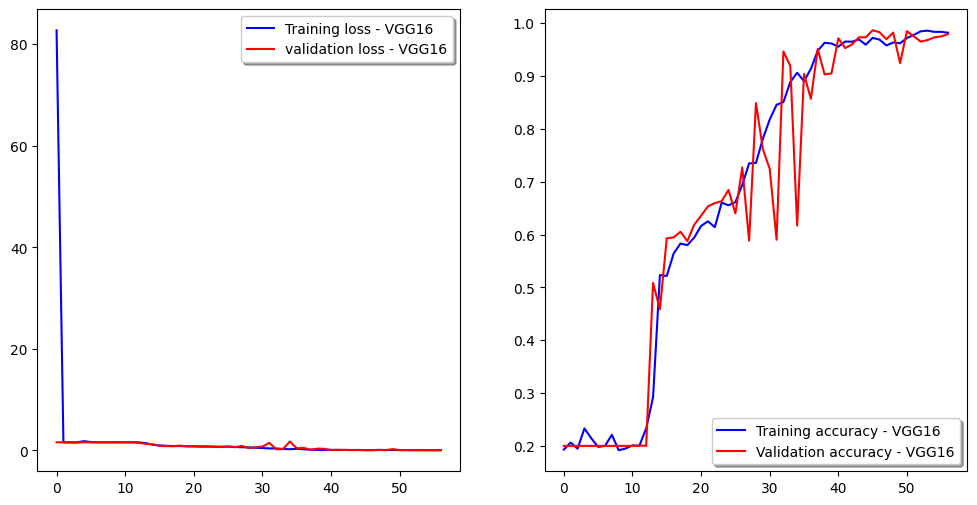

In [ ]:
fig,ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(history2.history['loss'], color='b', label="Training loss - VGG16")
ax[0].plot(history2.history['val_loss'], color='r', label="validation loss - VGG16",axes =ax[0])

legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history2.history['accuracy'], color='b', label="Training accuracy - VGG16")
ax[1].plot(history2.history['val_accuracy'], color='r',label="Validation accuracy - VGG16")

legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
score2 = model2.evaluate(validation_generator)
print("Test Accuracy:", score2[1])
print("Test Loss:", score2[0])

9/9 [==============================] - 3s 309ms/step - loss: 0.0707 - accuracy: 0.9796
Test Accuracy: 0.9795555472373962
Test Loss: 0.07068214565515518


In [ ]:
score_train2=model2.evaluate(train_generator)
print("Train Accuracy:", score_train2[1])
print("Train Loss:", score_train2[0])

24/24 [==============================] - 40s 2s/step - loss: 0.0448 - accuracy: 0.9863
Train Accuracy: 0.9863333106040955
Train Loss: 0.04484691470861435


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("/content/gdrive/MyDrive/TCC_Isis_Maranhao/CODIGO/2_VGG16/Confution_Matrix_VGG16.jpg")

30/30 [==============================] - 10s 310ms/step
Classification Report - VGG16
              precision    recall  f1-score   support

     Arborio       0.91      0.99      0.95       750
     Basmati       1.00      0.95      0.97       750
      Ipsala       0.99      1.00      0.99       750
     Jasmine       0.95      0.97      0.96       750
   Karacadag       1.00      0.94      0.97       750

    accuracy                           0.97      3750
   macro avg       0.97      0.97      0.97      3750
weighted avg       0.97      0.97      0.97      3750



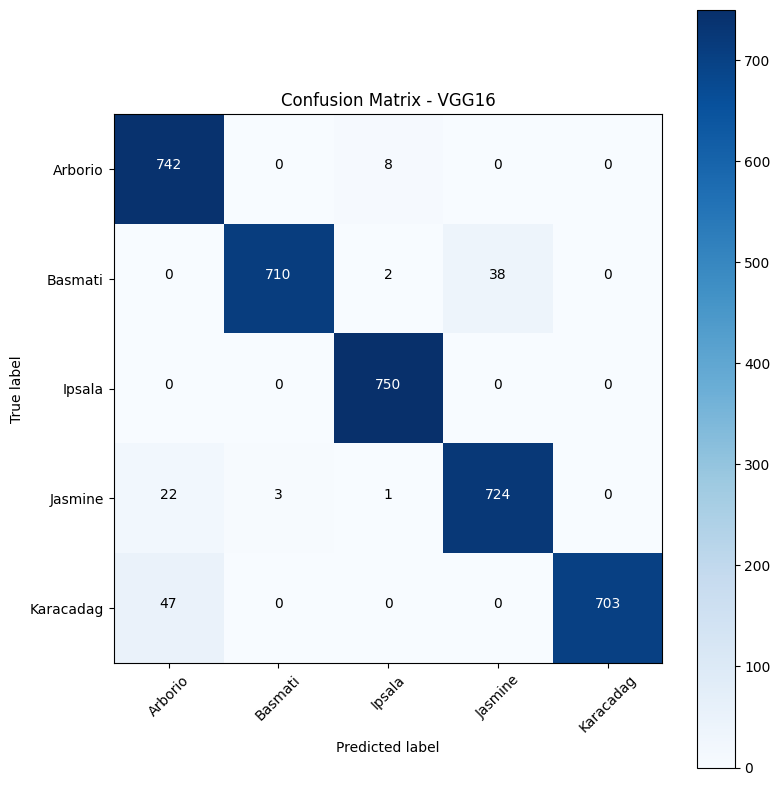

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model2.predict(test_generator, steps=nb_test_samples // BATCH_SIZE, workers=1)

y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix - VGG16')

print('Classification Report - VGG16')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))